In [2]:
from glob import glob
import pathlib
import pandas as pd
import numpy as np
import math
import re
from polyphys.manage import organizer
from polyphys.manage.parser import SumRule
from polyphys.probe import prober
from polyphys.analyze import analyzer
from polyphys.analyze import distributions
import MDAnalysis as mda
from 
import maicos

import seaborn as sns
import matplotlib.pyplot as plt

/Users/amirhsi_mini/opt/anaconda3/envs/polyLab/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
/Users/amirhsi_mini/opt/anaconda3/envs/polyLab/lib/python3.9/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


In [1]:
from dask.distributed import Client
from dask import delayed
from dask import compute
client = Client(n_workers=4)
client

distributed.diskutils - INFO - Found stale lock file and directory '/Users/amirhsi_mini/OneDrive - University of Waterloo/PhD Research/Jupyter/PolyPhys/tests/dask-worker-space/worker-oqfdoxk8', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/amirhsi_mini/OneDrive - University of Waterloo/PhD Research/Jupyter/PolyPhys/tests/dask-worker-space/worker-h0u6byxg', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/amirhsi_mini/OneDrive - University of Waterloo/PhD Research/Jupyter/PolyPhys/tests/dask-worker-space/worker-hbtcaput', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/amirhsi_mini/OneDrive - University of Waterloo/PhD Research/Jupyter/PolyPhys/tests/dask-worker-space/worker-cq9rp865', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52427,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:52438,Total threads: 2
Dashboard: http://127.0.0.1:52443/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:52432,


In [ ]:
data = np.stack([np.random.uniform(3,30,size=1000),
                 np.random.uniform(2,20,size=1000),
                 np.random.uniform(4,40,size=1000)]).T
edges = np.stack([np.arange(3,33,3),np.arange(2,22,2),np.arange(4,44,4)])
hists, _ = np.histogramdd(data, bins=edges)

In [ ]:
grid = np.zeros(hists.shape)
grid *= 0.0

In [ ]:
print(edges)
dedges = [np.diff(edge) for edge in edges]
print(dedges)
D = len(edges)
print(D)

In [ ]:
dedges

In [ ]:

for i in range(D):
    shape = np.ones(D, int)
    shape[i] = len(dedges[i])
    print(shape)
    print(dedges[i].reshape(shape))
    grid = hists / dedges[i].reshape(shape)

In [ ]:
grid

## Test maicos:

In [ ]:
path = pathlib.Path('/Users/amirhsi_mini/trjs/N500D10.0ac0.8-trjs')
path = path.resolve() # convert relative path to aabsolute one
input_database = str(path)
geometry = 'biaxial'
group = 'all'
hierarchy = '/N*/N*'
observations = glob(input_database + hierarchy)
# 'bug' time series and historams
topologies = organizer.sort_filenames(observations, fmts=['.all.data'])
trajectories = organizer.sort_filenames(observations, fmts=['.all.lammpstrj'])
# 'bug' time series and historams
sim_real_dt = 1000 * 0.002 * 1

topologies

In [ ]:
trajectories

In [ ]:
cell2 = mda.Universe(
        topologies[0][0],
        trajectories[1][0],
        topology_format='DATA',
        format='LAMMPSDUMP',
        lammps_coordinate_convention='unscaled',
        atom_style="id resid type x y z",
        dt=sim_real_dt
    )

In [ ]:
cell2.dimensions

In [ ]:
sim_info = SumRule(topologies[0][0], geometry='biaxial', group='bug',lineage='whole')

In [ ]:
np.prod(cell2.dimensions[:3])

In [ ]:
cell2.trajectory[0].volume


In [ ]:
crds = cell2.select_atoms('resid 0')  # crowders
dim =2
n_bins = 1000
dz = cell2.trajectory[0].dimensions[dim] / n_bins
bins = np.rint(crds.atoms.positions[:, dim] / dz)
#bins %= self.n_bins


In [ ]:
bins % n_bins

In [ ]:
crds.atoms.positions

In [ ]:
#mon = cell.select_atoms('resid 1')  # crowders
crds = cell2.select_atoms('resid 0')  # crowders
dplan = maicos.density_planar(crds,dens='number',center=True, dim=2,binwidth=0.04, verbose=True)
dplan.run()

In [ ]:
maicos.density_planar(mon,dens='number',dim=2,binwidth=0.4,radius=0.5*sim_info.dcyl,z=sim_info.lcyl,verbose=True)

In [ ]:
zcoor = dplan.results['z']
dens = dplan.results['dens_mean']

In [ ]:
np.arange(10)

In [ ]:
dplan.results

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (12,6))
plt.plot(zcoor,dens,linewidth=2)
plt.xlabel("z coordinate [nanometer]")
plt.ylabel("density H2O [kg/m3]")
plt.show()

In [ ]:
path = pathlib.Path('/Users/amirhsi_mini/trjs/N500D10.0ac0.8-trjs')
path = path.resolve() # convert relative path to aabsolute one
input_database = str(path)
geometry = 'biaxial'
group = 'all'
hierarchy = '/N*/N*'
observations = glob(input_database + hierarchy)
if observations == []:
    raise OSError(
        "File not found in "
        f"'{input_database + hierarchy}'"
        )
topologies = organizer.sort_filenames(observations, fmts=['.all.data'])
trajectories = organizer.sort_filenames(observations, fmts=['.all.lammpstrj'])
# 'bug' time series and historams
save_to = analyzer.database_path(input_database, phase='probe', stage='segment', group=None)
trjs_computed = []
for topology in topologies:
    topo_info = SumRule(topology[0],geometry=geometry, group=group, lineage='whole')
    save_to_whole = save_to + '/' + topo_info.whole
    save_to_whole = pathlib.Path(save_to_whole) 
    try:
        save_to_whole.mkdir(parents=True, exist_ok=False)
    except FileExistsError as error:
        print(error)
        print(
            f"Directory '{save_to_whole}'"
            " exist. Files are saved/overwritten to an existing directoy.")
    finally:
        save_to_whole = str(save_to_whole) + '/'
    for trajectory in trajectories:
        trj_info = SumRule(trajectory[0],geometry=geometry, group=group, lineage='segment')
        if trj_info.whole == topo_info.whole:
            if trj_info.segment_id ==14:
                trj_delayed = delayed(prober.probe_all)(topology[0], trajectory[0], geometry, 'segment', save_to_whole, continuous=False)
                trjs_computed.append(trj_delayed)
            else:
                trj_delayed = delayed(prober.probe_all)(topology[0], trajectory[0], geometry, 'segment', save_to_whole, continuous=True)
                trjs_computed.append(trj_delayed)  

# Analyzing simulation data:
There are several ways of analyzing the topology and trajectory pairs, depending on the number of trajectory files per a topology file, the continuity of trjaectory files, organization of files in a directory, and the parallel or sequencial arrangment of the computing power

## Separated *whole* simulation directories:
On the cluster, *whole* simulations are organized into *whole* directories, where each *whole* directory contains all the files for a given *whole* simulation. The **gnuparallel** is used to parallalize the **probw** phase at the **shell** level. For this purpose, all the python modules and scripts are separatedly installed and run on each core. For instance, if 32 cores are available, then the files in 32 *whole* directories are simulatenously. However, each *whole* directory may contains multiple toplogy and trajectory pairs. Thus, there is parallelization at the level of *whole* directories, not that of the *segment* or *whole* trajectories inside a *whole* directory. Inside each *whole* directory, a python **main_probe.py** script analyzes the trajectories. In this python 




### trj segments 

In [ ]:
## This approach from HERE
path = pathlib.Path('../test_data/trjs-continuous/N500D10.0ac0.8-trjs')
path = path.resolve() # convert relative path to aabsolute one
input_database = str(path)
if not pathlib.Path(input_database).exists():
    raise OSError(f"'{input_database}'"
                    "path does not exist.")
## to HERE, does not work of * is used in the string input for Path.
geometry = 'biaxial'
group = 'bug'
hierarchy = '/N*/N*'
observations = glob(input_database + hierarchy)
if observations == []:
    raise OSError(
        "File not found in "
        f"'{input_database + hierarchy}'"
        )
topologies = organizer.sort_filenames(observations, fmts=['.bug.data'])
trajectories = organizer.sort_filenames(observations, fmts=['.bug.lammpstrj'])
# 'bug' time series and historams
save_to = analyzer.database_path(input_database, phase='probe', stage='segment', group=None)
for topology in topologies:
    print(topology[0])
    topo_info = SumRule(topology[0],geometry=geometry, group=group, lineage='whole')
    save_to_whole = save_to + '/' + topo_info.whole
    save_to_whole = pathlib.Path(save_to_whole) 
    try:
        save_to_whole.mkdir(parents=True, exist_ok=False)
    except FileExistsError as error:
        print(error)
        print(
            f"Directory '{save_to_whole}'"
            " exist. Files are saved/overwritten to an existing directoy.")
    finally:
        save_to_whole = str(save_to_whole) + '/'
    for trajectory in trajectories:
        trj_info = SumRule(trajectory[0],geometry=geometry, group=group, lineage='segment')
        if trj_info.whole == topo_info.whole:
            if trj_info.segment_id ==10:
                prober.probe_bug(topology[0], trajectory[0], geometry, 'segment', save_to_whole)
            else:
                prober.probe_bug(topology[0], trajectory[0], geometry, 'segment', save_to_whole, continuous=True)

### bug whole trjs 

### trjs whole

In [ ]:
## This approach from HERE
path = pathlib.Path('/Users/amirhsi_mini/trjs/N500D10.0ac0.8-trjs')
path = path.resolve() # convert relative path to aabsolute one
input_database = str(path)
if not pathlib.Path(input_database).exists():
    raise OSError(f"'{input_database}'"
                    "path does not exist.")
## to HERE, does not work of * is used in the string input for Path.
geometry = 'biaxial'
group = 'bug'
hierarchy = '/N*/N*'
observations = glob(input_database + hierarchy)
if observations == []:
    raise OSError(
        "File not found in "
        f"'{input_database + hierarchy}'"
        )
topologies = organizer.sort_filenames(observations, fmts=['.bug.data'])
trajectories = organizer.sort_filenames(observations, fmts=['.bug.lammpstrj'])
# 'bug' time series and historams
save_to = analyzer.database_path(input_database, phase='probe', stage='segment', group=None)
for topology in topologies:
    print(topology[0])
    topo_info = SumRule(topology[0],geometry=geometry, group=group, lineage='whole')
    save_to_whole = save_to + '/' + topo_info.whole
    save_to_whole = pathlib.Path(save_to_whole) 
    try:
        save_to_whole.mkdir(parents=True, exist_ok=False)
    except FileExistsError as error:
        print(error)
        print(
            f"Directory '{save_to_whole}'"
            " exist. Files are saved/overwritten to an existing directoy.")
    finally:
        save_to_whole = str(save_to_whole) + '/'
    for trajectory in trajectories:
        trj_info = SumRule(trajectory[0],geometry=geometry, group=group, lineage='whole')
        if trj_info.whole == topo_info.whole:
            prober.probe_bug(topology[0], trajectory[0], geometry, 'whole', save_to_whole, continuous=False)

### bug whole trjs dask

In [ ]:
## This approach from HERE
path = pathlib.Path('/Users/amirhsi_mini/trjs/N500D10.0ac0.8-trjs')
path = path.resolve() # convert relative path to aabsolute one
input_database = str(path)
if not pathlib.Path(input_database).exists():
    raise OSError(f"'{input_database}'"
                    "path does not exist.")
## to HERE, does not work of * is used in the string input for Path.
geometry = 'biaxial'
group = 'bug'
hierarchy = '/N*/N*'
observations = glob(input_database + hierarchy)
if observations == []:
    raise OSError(
        "File not found in "
        f"'{input_database + hierarchy}'"
        )
topologies = organizer.sort_filenames(observations, fmts=['.bug.data'])
trajectories = organizer.sort_filenames(observations, fmts=['.bug.lammpstrj'])
# 'bug' time series and historams
save_to = analyzer.database_path(input_database, phase='probe', stage='segment', group=None)
trjs_computed = []
for topology in topologies:
    print(topology[0])
    topo_info = SumRule(topology[0],geometry=geometry, group=group, lineage='whole')
    save_to_whole = save_to + '/' + topo_info.whole
    save_to_whole = pathlib.Path(save_to_whole) 
    try:
        save_to_whole.mkdir(parents=True, exist_ok=False)
    except FileExistsError as error:
        print(error)
        print(
            f"Directory '{save_to_whole}'"
            " exist. Files are saved/overwritten to an existing directoy.")
    finally:
        save_to_whole = str(save_to_whole) + '/'
    for trajectory in trajectories:
        trj_info = SumRule(trajectory[0],geometry=geometry, group=group, lineage='whole')
        if trj_info.whole == topo_info.whole:
            trj_delayed = delayed(prober.probe_bug)(topology[0], trajectory[0], geometry, 'whole', save_to_whole, continuous=False)
            trjs_computed.append(trj_delayed)

In [ ]:
results = compute(trjs_computed)

# probe all

### all trj segments on pc:

In [ ]:
path = pathlib.Path('../test_data/trjs-continuous/N500D10.0ac0.8-trjs')
path = path.resolve() # convert relative path to aabsolute one
input_database = str(path)
geometry = 'biaxial'
group = 'all'
hierarchy = '/N*/N*'
if not pathlib.Path(input_database).exists():
    raise OSError(f"'{input_database}'"
                    "path does not exist.")
observations = glob(input_database + hierarchy)
if observations == []:
    raise OSError(
        "File not found in "
        f"'{input_database + hierarchy}'"
        )
topologies = organizer.sort_filenames(observations, fmts=['.all.data'])
trajectories = organizer.sort_filenames(observations, fmts=['.all.lammpstrj'])
# 'bug' time series and historams
save_to = analyzer.database_path(input_database, phase='probe', stage='segment', group=None)
for topology in topologies:
    topo_info = SumRule(topology[0],geometry=geometry, group=group, lineage='whole')
    save_to_whole = save_to + '/' + topo_info.whole
    save_to_whole = pathlib.Path(save_to_whole) 
    try:
        save_to_whole.mkdir(parents=True, exist_ok=False)
    except FileExistsError as error:
        print(error)
        print(
            f"Directory '{save_to_whole}'"
            " exist. Files are saved/overwritten to an existing directoy.")
    finally:
        save_to_whole = str(save_to_whole) + '/'
    for trajectory in trajectories:
        trj_info = SumRule(trajectory[0],geometry=geometry, group=group, lineage='segment')
        if trj_info.segment_id ==10:
            prober.probe_all(topology[0], trajectory[0], geometry, 'segment', save_to_whole)
        else:
            prober.probe_all(topology[0], trajectory[0], geometry, 'segment', save_to_whole, continuous=True)

In [ ]:
path = pathlib.Path('../test_data/trjs-continuous/N500D10.0ac0.8-trjs')
path = path.resolve() # convert relative path to aabsolute one
input_database = str(path)
geometry = 'biaxial'
hierarchy = '/N*/N*'
observations = glob(input_database + hierarchy)
all_tuples =  organizer.sort_filenames(observations,fmts=['all.lammpstrj'])
all_trjs = [all_tuple[0] for all_tuple in all_tuples]
all_data =  organizer.sort_filenames(observations,fmts=['all.data'])
all_data = all_data[0][0]

    
for all_trj in all_trjs:
    print(all_trj)
    #PipeLine.extract_trj_all(all_data, all_trj, geom, save_to)

### trjs all segments dask:

In [4]:
path = pathlib.Path('/Users/amirhsi_mini/trjs/N500D10.0ac0.8-trjs')
path = path.resolve() # convert relative path to aabsolute one
input_database = str(path)
geometry = 'biaxial'
group = 'all'
hierarchy = '/N*/N*'
if not pathlib.Path(input_database).exists():
    raise OSError(f"'{input_database}'"
                    "path does not exist.")
observations = glob(input_database + hierarchy)
if observations == []:
    raise OSError(
        "File not found in "
        f"'{input_database + hierarchy}'"
        )
topologies = organizer.sort_filenames(observations, fmts=['.all.data'])
trajectories = organizer.sort_filenames(observations, fmts=['.all.lammpstrj'])
# 'bug' time series and historams
save_to = analyzer.database_path(input_database, phase='probe', stage='segment', group=None)
trjs_computed = []
for topology in topologies:
    topo_info = SumRule(topology[0],geometry=geometry, group=group, lineage='whole')
    save_to_whole = save_to + '/' + topo_info.whole
    save_to_whole = pathlib.Path(save_to_whole) 
    try:
        save_to_whole.mkdir(parents=True, exist_ok=False)
    except FileExistsError as error:
        print(error)
        print(
            f"Directory '{save_to_whole}'"
            " exist. Files are saved/overwritten to an existing directoy.")
    finally:
        save_to_whole = str(save_to_whole) + '/'
    for trajectory in trajectories:
        trj_info = SumRule(trajectory[0],geometry=geometry, group=group, lineage='segment')
        if trj_info.whole == topo_info.whole:
            if trj_info.segment_id ==14:
                trj_delayed = delayed(prober.probe_all_new)(topology[0], trajectory[0], geometry, 'segment', save_to_whole, continuous=False)
                trjs_computed.append(trj_delayed)
            else:
                trj_delayed = delayed(prober.probe_all_new)(topology[0], trajectory[0], geometry, 'segment', save_to_whole, continuous=True)
                trjs_computed.append(trj_delayed)  

[Errno 17] File exists: '//Users/amirhsi_mini/probe/N500D10.0ac0.8-segment'
Directory '//Users/amirhsi_mini/probe/N500D10.0ac0.8-segment' exist. Files are saved/overwritten to an existing directory.
[Errno 17] File exists: '//Users/amirhsi_mini/probe/N500D10.0ac0.8-segment/N500epsilon5.0r5.5lz205.5sig0.8nc12012dt0.002bdump1000adump5000ens1'
Directory '//Users/amirhsi_mini/probe/N500D10.0ac0.8-segment/N500epsilon5.0r5.5lz205.5sig0.8nc12012dt0.002bdump1000adump5000ens1' exist. Files are saved/overwritten to an existing directoy.
[Errno 17] File exists: '//Users/amirhsi_mini/probe/N500D10.0ac0.8-segment/N500epsilon5.0r5.5lz205.5sig0.8nc48047dt0.002bdump1000adump5000ens1'
Directory '//Users/amirhsi_mini/probe/N500D10.0ac0.8-segment/N500epsilon5.0r5.5lz205.5sig0.8nc48047dt0.002bdump1000adump5000ens1' exist. Files are saved/overwritten to an existing directoy.


In [5]:
results = compute(trjs_computed)

/Users/amirhsi_mini/opt/anaconda3/envs/polyLab/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
/Users/amirhsi_mini/opt/anaconda3/envs/polyLab/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
/Users/amirhsi_mini/opt/anaconda3/envs/polyLab/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
/Users/amirhsi_mini/opt/anaconda3/envs/polyLab/lib/python3.9/site-package

### wholes

In [ ]:
input_database = '../test_data/probe/N500D10.0ac0.8-segment'
geometry = 'biaxial'
phase = 'analysis'
stage = 'wholeSim'
group = 'bug'
hierarchy = '/N*/N*'
relation = 'tseries'
observations = glob(input_database + hierarchy)
if observations == []:
    raise OSError(
        "File not found in "
        f"'{input_database + hierarchy}'"
        )
observations = organizer.sort_filenames(observations, fmts=['bug-gyrTMon.npy'])
save_to = analyzer.database_path(input_database, phase=phase, stage=stage, group=group)
gyr_wholes = organizer.whole('gyrTMon', observations, geometry=geometry, group=group, relation=relation, save_to=save_to)

input_database = '../test_data/probe/N500D10.0ac0.8-segment'
geometry = 'biaxial'
phase = 'analysis'
stage = 'wholeSim'
group = 'all'
hierarchy = '/N*/N*'
relation = 'histogram'
observations = glob(input_database + hierarchy)
if observations == []:
    raise OSError(
        "File not found in "
        f"'{input_database + hierarchy}'"
        )
observations = organizer.sort_filenames(observations, fmts=['-all-rHistMon.npy'])
save_to = analyzer.database_path(input_database, phase=phase, stage=stage, group=group)
rhist_wholes = organizer.whole('rHistMon', observations, geometry=geometry, group=group, relation=relation, save_to=save_to)

input_database = '../test_data/probe/N500D10.0ac0.8-segment'
geometry = 'biaxial'
phase = 'analysis'
stage = 'wholeSim'
group = 'all'
hierarchy = '/N*/N*'
relation = 'bin_edge'
observations = glob(input_database + hierarchy)
if observations == []:
    raise OSError(
        "File not found in "
        f"'{input_database + hierarchy}'"
        )
observations = organizer.sort_filenames(observations, fmts=['-all-rEdgeMon.npy'])
save_to = analyzer.database_path(input_database, phase=phase, stage=stage, group=group)
redge_wholes = organizer.whole('rEdgeMon', observations, geometry=geometry, group=group, relation=relation, save_to=save_to)

### ensembles

In [ ]:
group = 'bug'
input_database = '../test_data/probe/N500D10.0ac0.8-segment'
phase = 'analysis'
stage = 'ens'
save_to = analyzer.database_path(input_database, phase=phase, stage=stage, group=group)
gyr_ens = organizer.ensemble(
    'gyrTMon',
    gyr_wholes,
    group=group,
    edge_wholes=None,
    save_to=save_to)
group = 'all'
input_database = '../test_data/probe/N500D10.0ac0.8-segment'
phase = 'analysis'
stage = 'ens'
save_to = analyzer.database_path(input_database, phase=phase, stage=stage, group=group)
rhist_ens = organizer.ensemble(
    'rHistMon',
    rhist_wholes,
    group=group,
    edge_wholes=redge_wholes,
    save_to=save_to)


### Ensemble averages

In [ ]:
group = 'bug'
input_database = '../test_data/probe/N500D10.0ac0.8-segment'
phase = 'analysis'
stage = 'ensAvg'
save_to = analyzer.database_path(input_database, phase=phase, stage=stage, group=group)
gyr_ens_avg = analyzer.ensemble_avg(
    'gyrTMon',
    gyr_ens,
    group=group,
    save_to=save_to)
group = 'all'
input_database = '../test_data/probe/N500D10.0ac0.8-segment'
phase = 'analysis'
stage = 'ensAvg'
save_to = analyzer.database_path(input_database, phase=phase, stage=stage, group=group)
rhist_ens_avg = analyzer.ensemble_avg(
    'rHistMon',
    rhist_ens,
    group=group,
    exclude=['bin_center'],
    save_to=save_to)

In [ ]:
gyr_ens_avg['N500D10.0ac0.8nc12012'].plot()

In [ ]:
rhist_ens['N500D10.0ac0.8nc12012']

## Distributions

In [ ]:
help(distributions.distributions_generator)

In [6]:
#hist_paths = glob('/Users/amirhsi_mini/probe/N500D10.0ac0.8-segment/N500epsilon5.0r5.5lz205.5sig0.8nc12012dt0.002bdump1000adump5000ens1/N500epsilon5.0r5.5lz205.5sig0.8nc12012dt0.002bdump1000adump5000ens1*')
hist_paths = glob('/Users/amirhsi_mini/probe/N500D10.0ac0.8-segment/N500epsilon5.0r5.5lz205.5sig0.8nc48047dt0.002bdump1000adump5000ens1/N500epsilon5.0r5.5lz205.5sig0.8nc48047dt0.002bdump1000adump5000ens1*')
species = 'Crd'
direction = 'z'
geometry='biaxial'
group='all'
segments = organizer.sort_filenames(
                hist_paths,
                fmts=['-' + direction + 'Hist' + species + '.npy']
            )
edge_segments = organizer.sort_filenames(
                hist_paths,
                fmts=['-' + direction + 'Edge' + species + '.npy']
            )
wholes = organizer.whole(
                direction + 'Hist' + species,
                segments,
                geometry=geometry,
                group=group,
                relation='histogram',
                save_to=None
            )
edge_wholes = organizer.whole(
                direction + 'Edge' + species,
                edge_segments,
                geometry=geometry,
                group=group,
                relation='bin_edge',
                save_to=None
            )
            # 'whole' dataframes, each with a 'whole' columns.
rho_wholes, phi_wholes = distributions.distributions_generator(
                wholes,
                edge_wholes,
                group,
                species,
                geometry,
                direction,
                save_to=None,
normalized=True)

In [7]:
wholes['N500epsilon5.0r5.5lz205.5sig0.8nc48047dt0.002bdump1000adump5000ens1']

array([     0,      0, 498028, ..., 496545,      0,      0])

In [9]:
edge_wholes

{'N500epsilon5.0r5.5lz205.5sig0.8nc48047dt0.002bdump1000adump5000ens1': array([-206.4, -206. , -205.6, ...,  205.6,  206. ,  206.4])}

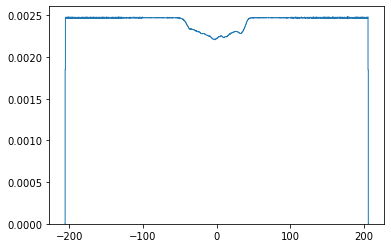

In [8]:
plt.hist(edge_wholes['N500epsilon5.0r5.5lz205.5sig0.8nc48047dt0.002bdump1000adump5000ens1'][:-1],edge_wholes['N500epsilon5.0r5.5lz205.5sig0.8nc48047dt0.002bdump1000adump5000ens1'],weights=wholes['N500epsilon5.0r5.5lz205.5sig0.8nc48047dt0.002bdump1000adump5000ens1'],histtype='step',density=True)
plt.show()

In [ ]:
sns.histplot(edge_wholes['N500epsilon5.0r5.5lz205.5sig0.8nc48047dt0.002bdump1000adump5000ens1'][:-1],bins=edge_wholes['N500epsilon5.0r5.5lz205.5sig0.8nc48047dt0.002bdump1000adump5000ens1'],weights=wholes['N500epsilon5.0r5.5lz205.5sig0.8nc48047dt0.002bdump1000adump5000ens1'])
plt.show()

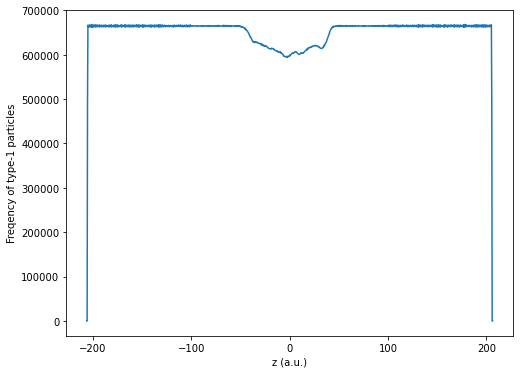

In [10]:
fig, axes = plt.subplots(nrows=1,ncols=1,sharex=True,figsize=(8,6))
centers = 0.5*(edge_wholes['N500epsilon5.0r5.5lz205.5sig0.8nc48047dt0.002bdump1000adump5000ens1'][:-1]+edge_wholes['N500epsilon5.0r5.5lz205.5sig0.8nc48047dt0.002bdump1000adump5000ens1'][1:])
hist_df = pd.DataFrame(wholes)
rho_df = pd.DataFrame(rho_wholes)
phi_df = pd.DataFrame(phi_wholes)
df = pd.concat([hist_df,rho_df,phi_df],axis=1)
df.columns = ['histogram','number_density','volume_fraction']
df['center'] = centers
#df['histogram'] = df['histogram'] / df['histogram'].sum()
df['fake']= 1
#df.set_index('center',inplace=True)
#sns.histplot(x='center',bins=edge_wholes['N500epsilon5.0r5.5lz205.5sig0.8nc48047dt0.002bdump1000adump5000ens1'] ,weights='volume_fraction',data=df,element='poly',fill=False, kde=True)
#plt.show()
#df['histogram'].plot(ax=axes,ylabel='histogram')
#sns.set_theme(style="whitegrid")
#sns.set(font_scale=1.2)
sns.axes_style("darkgrid")
sns.lineplot(x='center',y='histogram', data=df,ax=axes)
#df.loc[-200:200,'number_density'].plot(ax=axes[1],ylabel='number_density')
#df.loc[-200:200,'volume_fraction'].plot(ax=axes[2],ylabel='volume_fraction',xlabel='center')
#axes.grid()
#axes.set_xlim(df.index[0]-5, df.index[-1]+5)
#axes.axvline(df.loc[df.index[0],'center'],lw=0.5,c='red',label='left end')
#axes.axvline(df.loc[df.index[-1],'center'],lw=0.5,c='green',label='right end')
#axes.axvline(df['center'],lw=0.5,c='red')
axes.set_xlabel('z (a.u.)')
axes.set_ylabel('Freqency of type-1 particles')
#ax.set_xlim[]
plt.savefig('histogram.pdf',dpi=200)

In [11]:
df

,histogram,number_density,volume_fraction,center,fake
0,0,0.000000,0.000000,-206.2,1
1,0,0.000000,0.000116,-205.8,1
2,498028,0.000740,0.000664,-205.4,1
3,666552,0.000991,0.000951,-205.0,1
4,663002,0.000986,0.000987,-204.6,1
...,...,...,...,...,...
1027,663360,0.000986,0.000988,204.6,1
1028,667563,0.000992,0.000952,205.0,1
1029,496545,0.000738,0.000663,205.4,1
1030,0,0.000000,0.000115,205.8,1


In [ ]:
df['center'][-2:]

In [ ]:

name = 'N500epsilon5.0r5.5lz205.5sig0.8nc36036dt0.002bdump1000adump5000ens1'
hist_info = SumRule(name, geometry='biaxial', group='all', lineage='whole')
dist_new = distributions.Distribution(
    wholes[name],
    edges[name],
    hist_info,
    'dcrowd',
    geometry='biaxial',
    direction='z',
    normalized=False)

### whole_from_Segments

In [ ]:
input_database = '/Users/amirhsi_mini/probe/N500D10.0ac0.8-segment'
geometry = 'biaxial'
hierarchy = '/N*/N*'
lineage = 'segment'
observations = glob(input_database + hierarchy)
if observations == []:
    raise OSError(
        "File not found in "
        f"'{input_database + hierarchy}'"
        )
#save_to = analyzer.database_path(input_database, phase='analysis', stage='wholeSim', group=group)
#analyzer.analyze_segments(input_database, geometry, hierarchy)
analyzer.analyze_wholes(input_database, geometry, hierarchy)

In [ ]:
from dask.distributed import Client
from dask import delayed
from dask import compute
client = Client(n_workers=4)
client

### This script is used in GNU-Parallel

In [ ]:
from glob import glob
from PipeLine import *

fname = glob("../N*.bug.*")
fname = PipeLine.file_reader(fname) # This is a list with one member

save_to="./"
geom = 'cylindrical'
print(fname)
PipeLine.extract_trj_bug(fname[0], geom, save_to) # A list with one member, the member is a tuple of a trj and data pair.
#PipeLine.bug_trj_rmsd(fname[0], geom, save_to) 

trj_files = glob("./N*all.lammpstrj")
all_tuples = PipeLine.file_reader(trj_files,extensions=['lammpstrj'])
all_trjs = [all_tuple[0] for all_tuple in all_tuples]

data_file = glob("./N*.all.data")
all_data = PipeLine.file_reader(data_file,extensions=['all.data'])
all_data = all_data[0][0]

    
for all_trj in all_trjs:
    print(all_trj)
    PipeLine.extract_trj_all(all_data, all_trj, geom, save_to)

## Standard approach: Running on clusters: extraction from orgaznied *trjs_all* and *trjs_bug* directories

### This are not work properly on Graham cluster but work well on iMacmini

### 1. Extract from an organized *trjs_bug* directory:

In [ ]:
# This script extract different bug's information from pairs (toplogy and trajectory) of bug simulation files in oen or more organized *trjs_bug* directories.
from pathlib import Path
import os
from glob import glob
from PipeLine import *
from dask.distributed import Client
from dask import delayed
from dask import compute

cores = 32
print(f"number of workers set to {cores}; is this the same requested cores on the cluster?")
client = Client(n_workers=cores)
home = str(Path.home())
cwdir = str(Path.cwd())
# information extraction from simulations
geom = 'cylindrical'
fname = glob(home+'/amirhsi_rrg/cylinder_simulations/N*-trjs_bug/N*bug*')
bug_pairs = PipeLine.file_reader(fname) # each bug_pair is a pair of trajectory and topopgy file.
trjs_computed = []
bug_dir = 'extraction_bug/'
for bug_pair in bug_pairs:
    sim_name = bug_pair[0].split("/")[-1].split('bug')[0]
    sim_dir = cwdir+bug_dir+sim_name
    Path(sim_dir).mkdir(parents=True, exist_ok=False)
    sim_save_to = sim_dir+"/"
    trj_delayed = delayed(PipeLine.extract_trj_bug)(bug_pair, geom,sim_save_to)
    trjs_computed.append(trj_delayed)
results = compute(trjs_computed)

### 2. Extract from an organized *trjs_all* directory:

In [ ]:
# This script extract different bug's information from pairs (toplogy and trajectory) of bug simulation files in oen or more organized *trjs_bug* directories.
from pathlib import Path
import os
from glob import glob
from PipeLine import *
from dask.distributed import Client
from dask import delayed
from dask import compute

cores = 32
print(f"number of workers set to {cores}; is this the same requested cores on the cluster?")
client = Client(n_workers=cores)
home = str(Path.home())
cwdir = str(Path.cwd())
sim_all_dirs = glob(home+'/amirhsi_rrg/cylinder_simulations/N*-trjs_all/N*/')
geom = 'cylindrical'

trjs_computed = []
all_extraction_dir = 'extraction_all/'
for sim_all_dir in sim_all_dirs:
    sim_name = sim_all_dir[0].split("/")[-1]
    all_trjs = glob(sim_all_dir+"N*.lammpstrj")
    all_trjs = PipeLine.file_reader(all_trjs,extensions=['lammpstrj'])
    all_trjs = [all_trj[0] for all_trj in all_trjs]

    all_topology = glob(sim_all_dir+"N*.all.data")
    all_topology = PipeLine.file_reader(all_topology,extensions=['all.data'])
    all_topology = all_topology[0][0]
    
    
    sim_extract_dir = cwdir+all_extraction_dir+sim_name
    Path(sim_extract_dir).mkdir(parents=True, exist_ok=False)
    sim_save_to = sim_extract_dir+"/"
    
    for all_trj in all_trjs:
        trj_delayed = delayed(PipeLine.extract_trj_all)(all_topology, all_trj, geom,sim_save_To)
        trjs_computed.append(trj_delayed)

results = compute(trjs_computed)

## Extraction from *extraction_bug* directory after a simulation

In [ ]:
home = str(Path.home())
path=home+'N2000epsilon5.0r10.5lz336sig1.0nc100800dt0.005bdump1000adump5000ens1'
fname = glob(path+"/N*.bug.*")
fname = PipeLine.file_reader(fname) # This is a list with one member
geom = 'cylindrical'
print(fname)
PipeLine.extract_trj_bug(fname[0], geom) # A list with one member, the member is a tuple of a trj and data pair.
PipeLine.rmsd_trj_bug(fname[0], geom)

In [ ]:
# all the segments in one trajectory: M dump files + one data file.
path='/Users/amirhsi_mini/N2000epsilon5.0r10.5lz336sig1.0nc100800dt0.005bdump1000adump5000ens*'
geom = 'cylindrical'
trj_files = glob(path+"/N*.lammpstrj")
all_tuples = PipeLine.file_reader(trj_files,extensions=['lammpstrj',])
all_trjs = [all_tuple[0] for all_tuple in all_tuples]
data_file = glob(path+"/N*.all.data")
all_data = PipeLine.file_reader(data_file,extensions=['all.data'])
all_data = all_data[0][0]
for all_trj in all_trjs:
    PipeLine.extract_trj_all(all_data, all_trj, geom)

## New approach: tested on iMac Pro:

### A single ensemble with one or more segments with one data file

In [ ]:
path='/Users/amirhsi_mini/N2000epsilon5.0r15.5lz379.5sig6.0nc1068dt0.005bdump1000adump5000ens*'
#path='/Users/amirhsi_mini/N1000epsilon5.0r8.0lz308.5sig2.0nc10412dt0.005bdump1000adump5000ens*'
geom = 'cylindrical'
trj_files = glob(path+"/N*all*")
all_pairs = PipeLine.file_reader(trj_files)
trjs_computed = []
for all_pair in all_pairs:
    trj_delayed = delayed(PipeLine.extract_all_trj_polymer_cog_fsd)(all_pair[1], all_pair[0], geom)
    trjs_computed.append(trj_delayed)

In [ ]:
%%time
results = compute(trjs_computed)

### N ensemble with N data file, each ensemble with one or more segments 

In [ ]:
path='/Users/amirhsi_mini/N2000epsilon5.0r15.5lz379.5sig6.0nc1068dt0.005bdump1000adump5000ens*'
#path='/Users/amirhsi_mini/N1000epsilon5.0r8.0lz308.5sig2.0nc10412dt0.005bdump1000adump5000ens*'
geom = 'cylindrical'
trj_pathes = glob(path+"/N*all*")
trjs = PipeLine.file_reader(trj_pathes,extensions=['lammpstrj'])
trjs = [trj[0] for trj in trjs]
topology_pathes = glob(path+"/N*.all.data")
topologies = PipeLine.file_reader(topology_pathes,extensions=['all.data'])
topologies = [topology[0] for topology in topologies]

In [ ]:
def simulation(pair):
    """
    simulation_pair pairs an "all" topology file with all the "all" trjectories of that "all" topology.
    
    Parameters:
    pair (list of tuples): a list in whic each tuple is  pair of topolgy and trajectories of a simulations.
    
    Return:
    a dict of of simulation pairs.
    """
    return {'topology':pair[0], 'trajectories':pair[1]}

In [ ]:
ens_names = [topology.split("/")[-1].split('.all')[0] for topology in topologies]
ens_names = list(dict.fromkeys(ens_names))
trjs_per_ens = []
for ens_name in ens_names:
    ens_trjs = []
    for trj in trjs:
        trj_name = trj.split("/")[-1].split(".all")[0]
        if trj_name == ens_name:
            ens_trjs.append(trj)
            #ensembles[key]['trajectories'] = trj
    trjs_per_ens.append(ens_trjs)
ensembles= dict(zip(ens_names,list(map(simulation,list(zip(topologies,trjs_per_ens))))))

In [ ]:
geom = 'cylindrical'
trjs_computed = []
for ensemble in ensembles.values():
    for trj_segment in ensemble['trajectories']:
        trj_delayed = delayed(PipeLine.extract_trj_all)(ensemble['topology'], trj_segment, geom)
        trjs_computed.append(trj_delayed)

In [ ]:
%%time
results = compute(trjs_computed)